In [1]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, Lambda, LSTM, RepeatVector, TimeDistributed, Reshape, \
    Conv2D, MaxPooling2D, BatchNormalization, ConvLSTM2D, Bidirectional, Masking
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import scale

/Users/gzq/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/gzq/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = h5py.File("../dataset/data_sample.hdf5", "r")
images = data["images"][:]
labels = data["labels"][:]

def scale_images(images):
    t_images = np.transpose(images, (0,3,1,2))
    rt_images = t_images.reshape(72000*48, 21, 21)
    max_per_img = np.max(rt_images.reshape(-1, 21*21), axis=1, keepdims=1)
    scaled_images = rt_images.reshape(-1, 21*21) / max_per_img
    scaled_images = scaled_images.reshape(-1, 21, 21).reshape(-1, 48, 21, 21)
    return scaled_images

def txt2digit(labels):
    dic = {'Asteroids':0, 'Constant':1, 'EmptyLigh':2, 'M33Cephei':3, 'RRLyrae':4, 'Supernova':5}
    labels_digit = np.array([dic[i] for i in labels])
    return labels_digit


def build_dataset(images, labels, seq2seq=False):
    
    train_indices = np.random.choice(np.arange(images.shape[0]), int( 0.7 * images.shape[0]))
    val_indices = list(set(np.arange(images.shape[0])) - set(train_indices))
    
    x = images
    x = np.expand_dims(x, len(x.shape))
    y = to_categorical(txt2digit(labels))
    
    if seq2seq:
        y = np.repeat(y, 48).reshape(-1, 48, 6)
    
    return x, y


x, y = build_dataset(scale_images(images), labels)

In [3]:
def init_rcnn_stateful(cnn_input_dim=21, cnn_output_dim=128, cnn_dropout=0.25,
               rnn_hidden_dim=128, num_classes=6, rnn_dropout=0.5, timestep=48,
               bidir_mode='concat'):
    
    input_shape = (1, 1, cnn_input_dim, cnn_input_dim, 1)
    
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(48, (4,4), \
                     padding='same', activation='relu', kernel_initializer='uniform'), batch_input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))
    
    model.add(TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform')))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))

    model.add(TimeDistributed(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform')))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1))))
    
    model.add(TimeDistributed(Flatten()))

    model.add(TimeDistributed(Dense(cnn_output_dim, activation='relu')))
    model.add(Dropout(cnn_dropout))
    
    model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout, return_sequences=True, stateful=True)))
    model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout, stateful=True)))
    
    model.add(Dense(6, activation='softmax'))
    
    return model

In [4]:
def init_rcnn_masking(cnn_input_dim=21, cnn_output_dim=128, cnn_dropout=0.5,
               rnn_hidden_dim=128, num_classes=6, rnn_dropout=0.5, timestep=48,
               bidir_mode='concat'):
    
    input_shape = (timestep, cnn_input_dim, cnn_input_dim, 1)
    
    model = Sequential()
    
    model.add(TimeDistributed(Masking(mask_value=0.0), input_shape=input_shape, name='Masking'))
    model.add(TimeDistributed(Conv2D(48, (4,4), \
                     padding='same', activation='relu', kernel_initializer='uniform'), \
                              input_shape=input_shape, name='Conv2D_1'))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_1'))
    
    model.add(TimeDistributed(Conv2D(24, (3,3), padding='same', activation='relu', kernel_initializer='uniform'),\
                 name='Conv2D_2'))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_2'))

    model.add(TimeDistributed(Conv2D(12, (3,3), padding='same', activation='relu', kernel_initializer='uniform'), \
                             name='Conv2D_3'))
    model.add(TimeDistributed(MaxPooling2D((3,3), strides=(1,1)), name='MaxPooling2D_3'))
    
    model.add(TimeDistributed(Flatten(), name='Flatten'))

    model.add(TimeDistributed(Dense(cnn_output_dim, activation='relu'), name='Dense_128'))
    model.add(Dropout(cnn_dropout))
    
    model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout, return_sequences=True, name='LSTM_1')))
    model.add(Bidirectional(LSTM(rnn_hidden_dim, dropout=rnn_dropout, name='LSTM_2')))
    model.add(Dense(6, activation='softmax', name='Output_Dense'))
    
    return model

In [5]:
class online_classifier:
    
    def __init__(self, trained_model, mode):
        """
        Initializer. Pass in trained model and mode ("stateful" or "masking")
        """
        if mode == 'stateful':
            self.model = init_rcnn_stateful()
        elif mode == 'masking':
            self.model = init_rcnn_masking()
            
        weights = trained_model.get_weights()
        self.model.set_weights(weights)
        self.mode = mode
        self.data = np.zeros((48,21,21))
        self.epoch = 0
        self.predictions = []
        self.labels = ['Asteroids', 'Constant', 'EmptyLigh', 'M33Cephei', 'RRLyrae', 'Supernova']
        self.pred = ''
        
    def upload_image(self, image):
        """
        Upload an image of shape (1,21,21)
        """
        self.data[self.epoch:self.epoch+1,:,:] = image
        
        if self.mode == 'stateful':
            prob = self.model.predict(self.data[self.epoch,:,:].reshape([1,1,21,21,1]))[0]
        if self.mode == 'masking':
            prob = self.model.predict(self.data.reshape(1,48,21,21,1))[0]
        self.predictions.append(prob)
        pred_idx = np.argmax(prob)
        self.pred = self.labels[pred_idx]
        self.epoch += 1
        
    def predict(self):
        """
        Show current prediction and class probabilities history.
        """
        
        print('Prediction: %s (with %f probability)' %(self.pred, max(self.predictions[-1])))
        
        import matplotlib.pyplot as plt
        import seaborn as sns
        x= range(1, len(self.predictions)+1)
        y= np.array(self.predictions).T
        
        sns.set_palette("RdBu_r", 6)
        plt.stackplot(x,y, labels=self.labels, cmap=sns.dark_palette("palegreen", as_cmap=True))
        plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
        plt.xlabel('Epoch')
        plt.ylabel('Class Probabilities')
        plt.show()
        return self.pred, self.predictions
    
    def reset(self):
        """
        Reset to epoch 1. All predictions and data will be removed.
        """
        self.epoch = 0
        self.predictions = []
        self.pred = ''
        self.data = np.zeros((48,21,21))

In [6]:
# Load trained model
model = keras.models.load_model('saved_models/rcnn_ep200.hdf5')

In [36]:
# Initialize online classifier
clf = online_classifier(model, 'stateful')

In [28]:
clf.model.layers[-2].supports_masking = True
clf.model.layers[-1].supports_masking = True

In [29]:
# Choose an image
index = 3
img = x[index,:,:,:,:].reshape((48,21,21))
print('True label: ', labels[index])

True label:  M33Cephei


Prediction: M33Cephei (with 0.988325 probability)


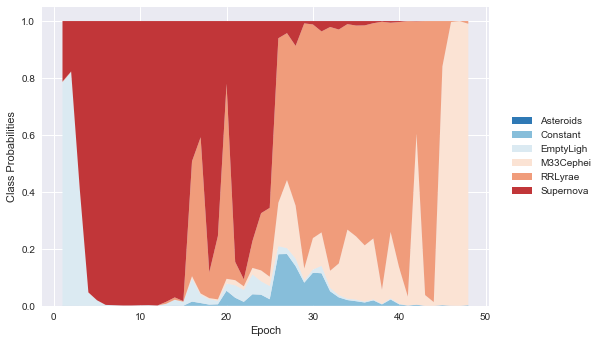

In [26]:
# Upload 10 epochs and predict
clf.reset()
for i in range(48):
    clf.upload_image(img[i,:,:].reshape(-1,21,21))
pred, history = clf.predict()

Prediction: M33Cephei (with 0.988325 probability)


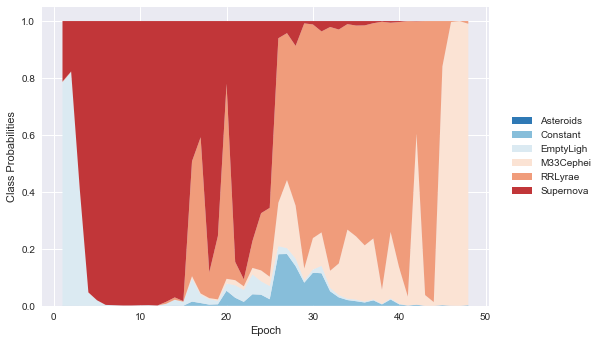

In [33]:
# Upload 10 epochs and predict
clf.reset()
for i in range(48):
    clf.upload_image(img[i,:,:].reshape(-1,21,21))
pred, history = clf.predict()

In [32]:
clf.model.supports_masking = True

In [35]:
clf.model.__dict__

{'_built': True,
 '_container_nodes': {'Conv2D_1_ib-0',
  'Conv2D_2_ib-0',
  'Conv2D_3_ib-0',
  'Dense_128_ib-0',
  'Flatten_ib-0',
  'Masking_ib-0',
  'Masking_input_ib-0',
  'MaxPooling2D_1_ib-0',
  'MaxPooling2D_2_ib-0',
  'MaxPooling2D_3_ib-0',
  'Output_Dense_ib-0',
  'bidirectional_7_ib-0',
  'bidirectional_8_ib-0',
  'dropout_4_ib-0'},
 '_feed_input_names': ['Masking_input'],
 '_feed_inputs': [<tf.Tensor 'Masking_input_3:0' shape=(?, 48, 21, 21, 1) dtype=float32>],
 '_inbound_nodes': [<keras.engine.topology.Node at 0x1b9c9ab940>],
 '_initial_weights': None,
 '_nodes_by_depth': {0: [<keras.engine.topology.Node at 0x1b9df33d68>],
  1: [<keras.engine.topology.Node at 0x1b9e36dfd0>],
  2: [<keras.engine.topology.Node at 0x1b9d9a3898>],
  3: [<keras.engine.topology.Node at 0x1b9c73b780>],
  4: [<keras.engine.topology.Node at 0x1b9c87d668>],
  5: [<keras.engine.topology.Node at 0x1b9c7e9320>],
  6: [<keras.engine.topology.Node at 0x1b9c6a7710>],
  7: [<keras.engine.topology.Node at 0x